In [1]:
# data stuff:
import pandas as pd
import numpy as np

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image

# stats stuff:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# modeling stuff:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## 📊 Engagement Analysis:
Below we cover:

* Logistic Regression
* Engagement Rate
&nbsp;




**📄 Dataset:** IBM Watson Marketing Customer Analytics (https://www.kaggle.com/datasets/pankajjsh06/ibm-watson-marketing-customer-value-data?select=WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv)

📚 See chapter 3 of _"Data Science for Marketing"_ by Hwang, page 76.

---

---
### Import data:

In [2]:
data = pd.read_csv('data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


&nbsp;

---
### Calculate Overall Engagement Rate:

In [3]:
# first, binarize the 'response' column into integers:
data['Engaged'] = data['Response'].apply(lambda x: 1 if x=='Yes' else 0)

# group by and calculate:
overall_ER_df = data.groupby('Response')['Engaged'].count().to_frame() / len(data['Engaged'])
overall_ER_df.T

Response,No,Yes
Engaged,0.856799,0.143201


In [4]:
overall_engagement = np.round(overall_ER_df['Engaged']['Yes']*100, 3)
print(f"Overall Engagement Rate: {overall_engagement}%")

Overall Engagement Rate: 14.32%


&nbsp;

---
### Calculate Engagement Rate by sales channel:

In [5]:
sales_channel_ER = data.pivot_table(index='Sales Channel', columns='Engaged', values='Response', aggfunc='count')
sales_channel_ER.columns = ['Not Engaged', 'Engaged']
sales_channel_ER

,Not Engaged,Engaged
Sales Channel,,
Agent,2811,666
Branch,2273,294
Call Center,1573,192
Web,1169,156


In [6]:
sales_channel_ER['Engagement Rate per Channel'] = np.round(sales_channel_ER['Engaged']/sales_channel_ER.sum(axis=1), 2)
sales_channel_ER['Engagement Rate across Channels'] = np.round(sales_channel_ER['Engaged']/sales_channel_ER.sum(axis=0)['Engaged'], 2)
sales_channel_ER

,Not Engaged,Engaged,Engagement Rate per Channel,Engagement Rate across Channels
Sales Channel,,,,
Agent,2811,666,0.19,0.51
Branch,2273,294,0.11,0.22
Call Center,1573,192,0.11,0.15
Web,1169,156,0.12,0.12


&nbsp;

In [7]:
# We can also use crosstab to get a contingency table to see the different counts across or by sales channel:
pd.crosstab(data['Sales Channel'], data['Response'], normalize='columns', margins=True)

Response,No,Yes,All
Sales Channel,,,
Agent,0.359187,0.509174,0.380666
Branch,0.290442,0.224771,0.281038
Call Center,0.200997,0.146789,0.193234
Web,0.149374,0.119266,0.145062


In [8]:
pd.crosstab(data['Sales Channel'], data['Response'], normalize='index', margins=True)

Response,No,Yes
Sales Channel,,
Agent,0.808456,0.191544
Branch,0.885469,0.114531
Call Center,0.891218,0.108782
Web,0.882264,0.117736
All,0.856799,0.143201


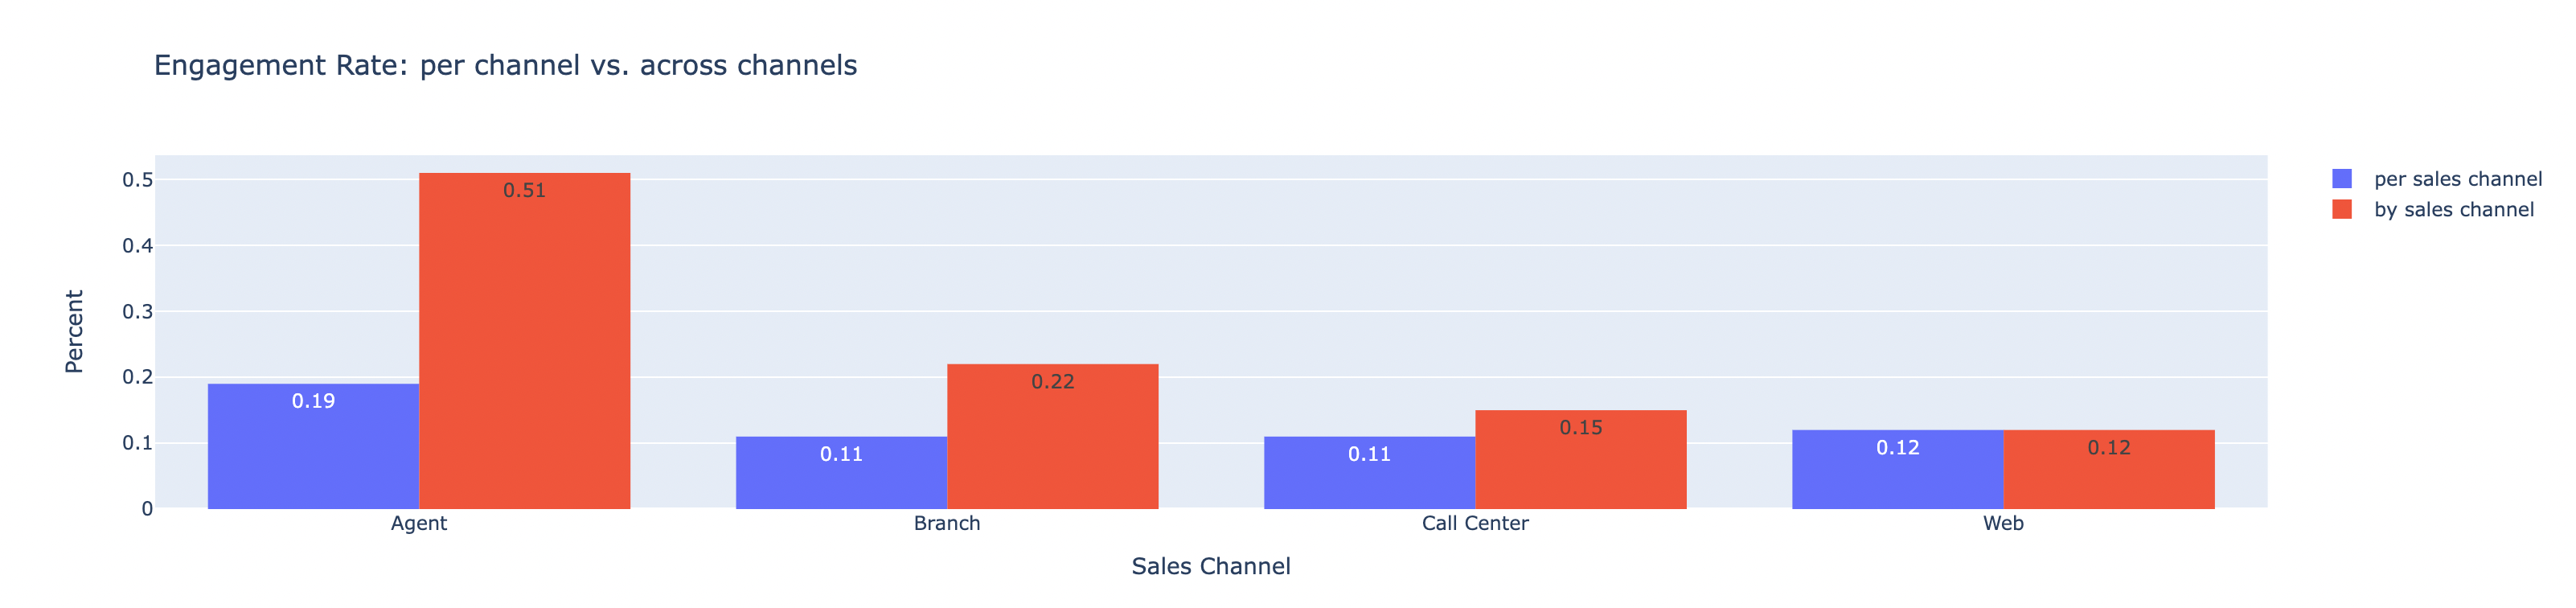

In [58]:
ER_fig = go.Figure()
ER_fig.add_trace(go.Histogram(histfunc="sum", 
                              y=sales_channel_ER['Engagement Rate per Channel'], 
                              x=list(sales_channel_ER.index), name='per sales channel', 
                              text=sales_channel_ER['Engagement Rate per Channel']))
ER_fig.add_trace(go.Histogram(histfunc="sum", 
                              y=sales_channel_ER['Engagement Rate across Channels'], 
                              x=list(sales_channel_ER.index), name='by sales channel', 
                              text=sales_channel_ER['Engagement Rate across Channels']))
# ER_fig.update_traces(textposition='inside')
ER_fig.update_layout(title_text="Engagement Rate: per channel vs. across channels",
                     height=400, 
                     xaxis_title_text='Sales Channel',
                     yaxis_title_text='Percent')
Image(filename='./images/ch3_1.png', width=1500)

The figure above tells us two things:
* the "Agent" sales channel is the most efficient when it comes to raking up engagement, with approx. 7% more engagement than the closes channel (Web)
* the "Agent" channel's engagement rate accounts for 51% of the entire engagement across all channels.

&nbsp;

----
### Calculate Total Claim Amount by Engagement Status

In [10]:
# obtain a summary:
claims_engagement = data.groupby('Response')['Total Claim Amount'].agg([min, 'median', max]).round(2)
claims_engagement.transpose()

Response,No,Yes
min,0.10,7.35
median,377.08,410.12
max,2893.24,1358.40


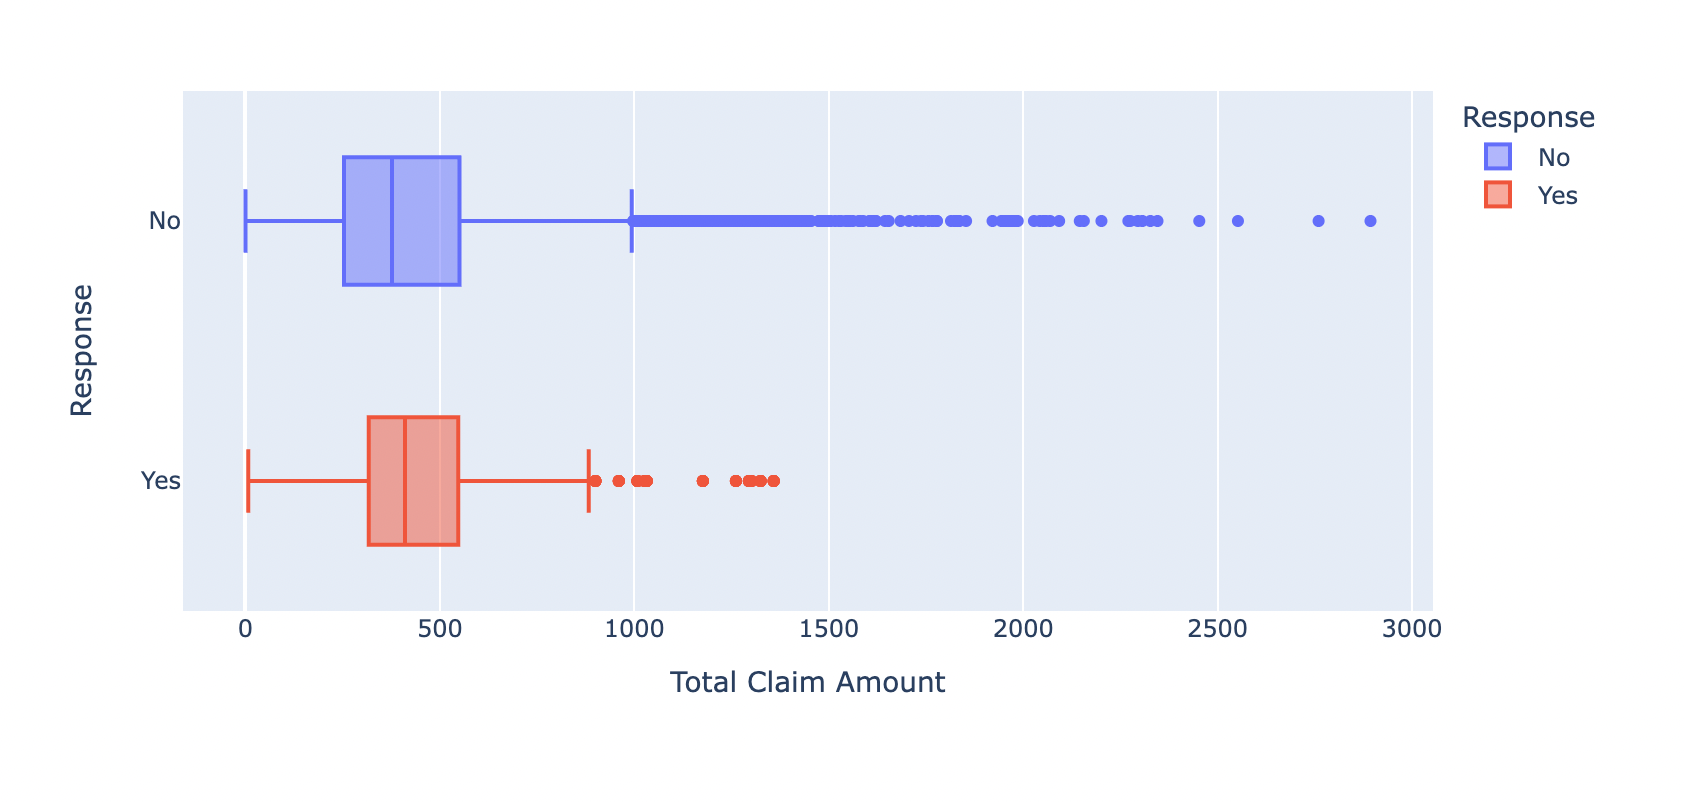

In [60]:
claims_fig = px.box(data, y='Response', x='Total Claim Amount', color='Response')
claims_fig.update_layout(height=400, width=800)
Image(filename='./images/ch3_2.png', width=1000)

&nbsp;

---
---
### Logistic Regression for Explanatory Analysis:
Below we apply logistic regression techniques to the dataset in order to predict whether or not a customer will engage with our marketing campaigns.

#### Determine variable types:

In [12]:
# get the numerical variables:
numericals = [x for x in data.columns if (data[x].dtype !='O') and (x!='Engaged')]
numericals

['Customer Lifetime Value',
 'Income',
 'Monthly Premium Auto',
 'Months Since Last Claim',
 'Months Since Policy Inception',
 'Number of Open Complaints',
 'Number of Policies',
 'Total Claim Amount']

&nbsp;

#### Split into train and test sets:
For the time being, we only consider purely numerical variables. We'll fit a model and evaluate, then incorporate categoricals.

In [13]:
# set target and predictor variables:
target = data['Engaged']
predictors = data[numericals]

# split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2)

&nbsp;

#### Initialize and fit Logistic Model:

In [14]:
# predictors = sm.add_constant(predictors)
log_reg_continuos = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.420951
         Iterations 6


In [15]:
# get summary:
log_reg_continuos.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Engaged   No. Observations:                 7307
Model:                          Logit   Df Residuals:                     7299
Method:                           MLE   Df Model:                            7
Date:                Mon, 13 Jun 2022   Pseudo R-squ.:                -0.02818
Time:                        14:29:17   Log-Likelihood:                -3075.9
converged:                       True   LL-Null:                       -2991.6
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Customer Lifetime Value       -6.298e-06   5.61e-06     -1.122      0.262   -1.73e-05    4.71e-06
Income                        -2.644e-06   1.16e-06     -2.284      0.022   -4.91e-06   -3.75e-07
Monthly Premium Auto             -0.0081      0.001     -5.998      0.000      -0.011      -0.005
Months Since Last Claim          -0.0194      0.003     -6.215      0.000      -0.025      -0.013
Months Since Policy Inception    -0.0063      0.001     -5.793      0.000      -0.008      -0.004
Number of Open Complaints        -0.0846      0.038     -2.230      0.026      -0.159      -0.010
Number of Policies               -0.0918      0.015     -6.326      0.000      -0.120      -0.063
Total Claim Amount                0.0001      0.000      0.592      0.554      -0.000       0.000
=================================================================================================
"""

As we can see above, the P-value for all features except Customer LTV, Total Claim Amount, and Number of Open Complaints is significant.

&nbsp;

#### Obtain predictions and evaluate:

In [16]:
# preds:
yhat = log_reg_continuos.predict(X_test)
prediction = list(map(round, yhat))

In [17]:
# get confusion matrix:
cm = confusion_matrix(y_test, prediction)
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[1560    0]
 [ 267    0]]
Test accuracy =  0.8538587848932676


Above, we can see that the model is not very good capturing the low prevalence class, which corresponds to the "Engaged" class or the "Response" = 'Yes' class.

&nbsp;

#### Add Categorical Variables to Logistic Model:
For the logistic model, we need to convert the categorical variables to numerical by encoding them.

In [18]:
# implement ordinal categorization of the employment variable:
employment_categories = pd.Categorical(data['EmploymentStatus'],
                                      categories=['Unemployed', 'Disabled', 'Medical Leave', 'Retired', 'Employed'],
                                      ordered=True)
data['EmploymentStatus factorized'] = employment_categories.codes

# implement ordinal categorization of the education variable:
education_categories = pd.Categorical(data['Education'],
                                      categories=['High School or Below', 'College', 'Bachelor', 'Master', 'Doctor'],
                                      ordered=True)
data['Education factorized'] = education_categories.codes

# implement ordinal categorization of the coverage variable:
coverage_categories = pd.Categorical(data['Coverage'],
                                      categories=['Basic', 'Extended', 'Premium'],
                                      ordered=True)
data['Coverage factorized'] = coverage_categories.codes


# factorize other categorical variables:
data['Gender Factorized'] = data['Gender'].factorize()[0]
data['Policy Type Factorized'] = data['Policy Type'].factorize()[0]
data['Sales Channel Factorized'] = data['Sales Channel'].factorize()[0]
data['Renew Offer Type factorized'] = data['Renew Offer Type'].factorize()[0]

# define cateogrical variables:
categoricals = data[['EmploymentStatus factorized', 'Education factorized', 'Coverage factorized',
                     'Gender Factorized', 'Policy Type Factorized', 'Sales Channel Factorized']]
categoricals.head()

,EmploymentStatus factorized,Education factorized,Coverage factorized,Gender Factorized,Policy Type Factorized,Sales Channel Factorized
0,4,2,0,0,0,0
1,0,2,1,0,1,0
2,4,2,2,0,1,0
3,0,2,0,1,0,1
4,4,2,0,1,1,0


In [19]:
# set new predictors:
new_predictors = predictors.join(categoricals)
new_predictors.head()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,EmploymentStatus factorized,Education factorized,Coverage factorized,Gender Factorized,Policy Type Factorized,Sales Channel Factorized
0,2763.519279,56274,69,32,5,0,1,384.811147,4,2,0,0,0,0
1,6979.535903,0,94,13,42,0,8,1131.464935,0,2,1,0,1,0
2,12887.431650,48767,108,18,38,0,2,566.472247,4,2,2,0,1,0
3,7645.861827,0,106,18,65,0,7,529.881344,0,2,0,1,0,1
4,2813.692575,43836,73,12,44,0,1,138.130879,4,2,0,1,1,0


In [20]:
# split again after adding new predictors:
X_train, X_test, y_train, y_test = train_test_split(new_predictors, target, test_size=0.2)
log_reg_mixed = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.404735
         Iterations 6


&nbsp;

#### Obtain new predictions and evaluate:

In [21]:
yhat_mixed = log_reg_mixed.predict(X_test)
prediction = list(map(round, yhat_mixed))

In [22]:
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[1539    0]
 [ 288    0]]
Test accuracy =  0.8423645320197044


This model did marginally better, but it is still just guessing the most prevalent class. We can do better with Gradient boosting.

&nbsp;

---
---
### Implement XGBoost Classifier:
Below we initialize the simplest of XGB classifiers; all default params.

In [23]:
# set the target variable back to the response since XGB can handle the categorical labels:
target = data['Response']

# set predictors:
numericals = data[numericals]
categoricals = categoricals
predictors_xgb = numericals.join(categoricals)

# split:
X_train, X_test, y_train, y_test = train_test_split(predictors_xgb, target, test_size=0.2)

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

[14:29:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

&nbsp;

#### Obtain XGB predictions and evaluate:

In [24]:
# XGB preds and accuracy:
preds_xgb = model.predict(X_test)
print(f'Test accuracy = {accuracy_score(y_test, preds_xgb)}')

Test accuracy = 0.9972632731253421


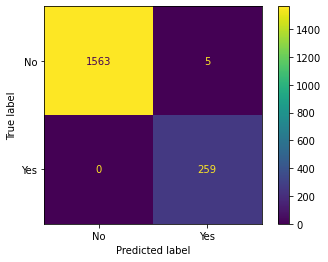

In [61]:
# plot confusion matrix:
plot_confusion_matrix(model, X_test, y_test);

&nbsp;

#### Get model Importances:

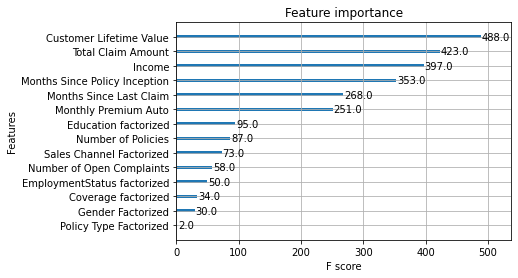

In [26]:
plot_importance(model);

&nbsp;

&nbsp;

#### Get SHAP Importances:
Below we call upon the SHAP Library to provide more clarity on feature importances.

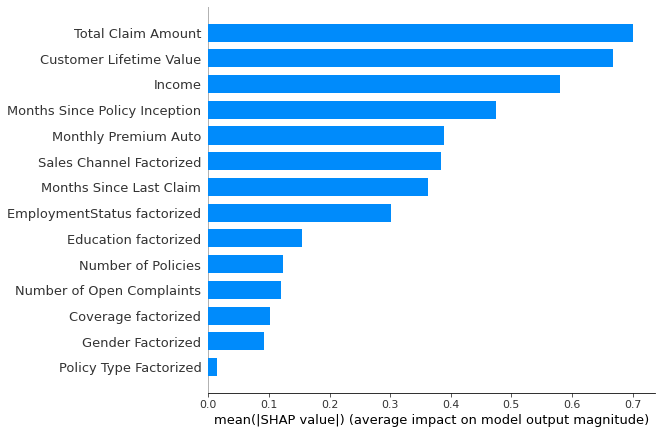

In [46]:
import shap

# instantiate explainer and fit on train set:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# plot summary:
shap.summary_plot(shap_values, X_train, plot_type='bar')

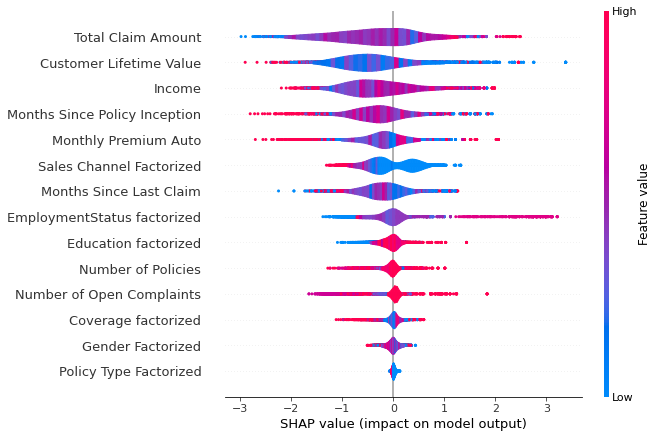

In [47]:
shap.summary_plot(shap_values, X_train, plot_type='violin')

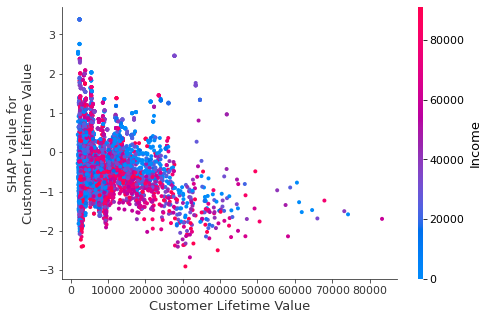

In [50]:
shap.dependence_plot('Customer Lifetime Value', shap_values, X_train, interaction_index='Income')

#### Conclusion:
The output of the XGB model above tells a better story than the logistic regression models we evaluated earlier. Not only do we get better predictive performance, but we also get much better explanatory power in terms of which features are boosting the model's predictive power. 

However, unlike the logistic models, we do not get a "coefficient" telling us whether the values are negatively or positively correlated with the target variable.